# Challenge#2: Find the bug in this linear regression model 

In linear models, the target value is modeled as
a linear combination of the features (see the `linear_model` User Guide
section for a description of a set of linear models available in
scikit-learn).
Coefficients in multiple linear models represent the relationship between the
given feature, $X_i$ and the target, $y$, assuming that all the
other features remain constant ([conditional dependence](https://en.wikipedia.org/wiki/Conditional_dependence)).
This is different from plotting $X_i$ versus $y$ and fitting a
linear relationship: in that case all possible values of the other features are
taken into account in the estimation (marginal dependence).

This example will provide some hints in interpreting coefficient in linear
models, pointing at problems that arise when either the linear model is not
appropriate to describe the dataset, or when features are correlated.

We will use data from the ["Current Population Survey"](https://www.openml.org/d/534) from 1985 to predict
wage as a function of various features such as experience, age, or education.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import median_absolute_error

## The dataset: wages

We fetch the data from [OpenML](http://openml.org/).
Note that setting the parameter `as_frame` to True will retrieve the data
as a pandas dataframe.



In [2]:
from sklearn.datasets import fetch_openml

survey = fetch_openml(data_id=534, as_frame=True)

Then, we identify features `X` and targets `y`: the column WAGE is our
target variable (i.e., the variable which we want to predict).



In [3]:
X = survey.data[survey.feature_names]
X.describe(include="all")

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
count,534.000000,534,534,534.000000,534,534.000000,534,534,534,534
unique,NaN,2,2,NaN,2,NaN,3,6,3,2
top,NaN,no,male,NaN,not_member,NaN,White,Other,Other,Married
freq,NaN,378,289,NaN,438,NaN,440,156,411,350
mean,13.018727,NaN,NaN,17.822097,NaN,36.833333,NaN,NaN,NaN,NaN
std,2.615373,NaN,NaN,12.379710,NaN,11.726573,NaN,NaN,NaN,NaN
min,2.000000,NaN,NaN,0.000000,NaN,18.000000,NaN,NaN,NaN,NaN
25%,12.000000,NaN,NaN,8.000000,NaN,28.000000,NaN,NaN,NaN,NaN
50%,12.000000,NaN,NaN,15.000000,NaN,35.000000,NaN,NaN,NaN,NaN
75%,15.000000,NaN,NaN,26.000000,NaN,44.000000,NaN,NaN,NaN,NaN


Note that the dataset contains categorical and numerical variables.
We will need to take this into account when preprocessing the dataset
thereafter.



In [4]:
X.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8.0,no,female,21.0,not_member,35.0,Hispanic,Other,Manufacturing,Married
1,9.0,no,female,42.0,not_member,57.0,White,Other,Manufacturing,Married
2,12.0,no,male,1.0,not_member,19.0,White,Other,Manufacturing,Unmarried
3,12.0,no,male,4.0,not_member,22.0,White,Other,Other,Unmarried
4,12.0,no,male,17.0,not_member,35.0,White,Other,Other,Married


Our target for prediction: the wage.
Wages are described as floating-point number in dollars per hour.



In [5]:
y = survey.target.values.ravel()
survey.target.head()

0    5.10
1    4.95
2    6.67
3    4.00
4    7.50
Name: WAGE, dtype: float64

We split the sample into a train and a test dataset.
Only the train dataset will be used in the following exploratory analysis.
This is a way to emulate a real situation where predictions are performed on
an unknown target, and we don't want our analysis and decisions to be biased
by our knowledge of the test data.



In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

First, let's get some insights by looking at the variable distributions and
at the pairwise relationships between them. Only numerical
variables will be used. In the following plot, each dot represents a sample.




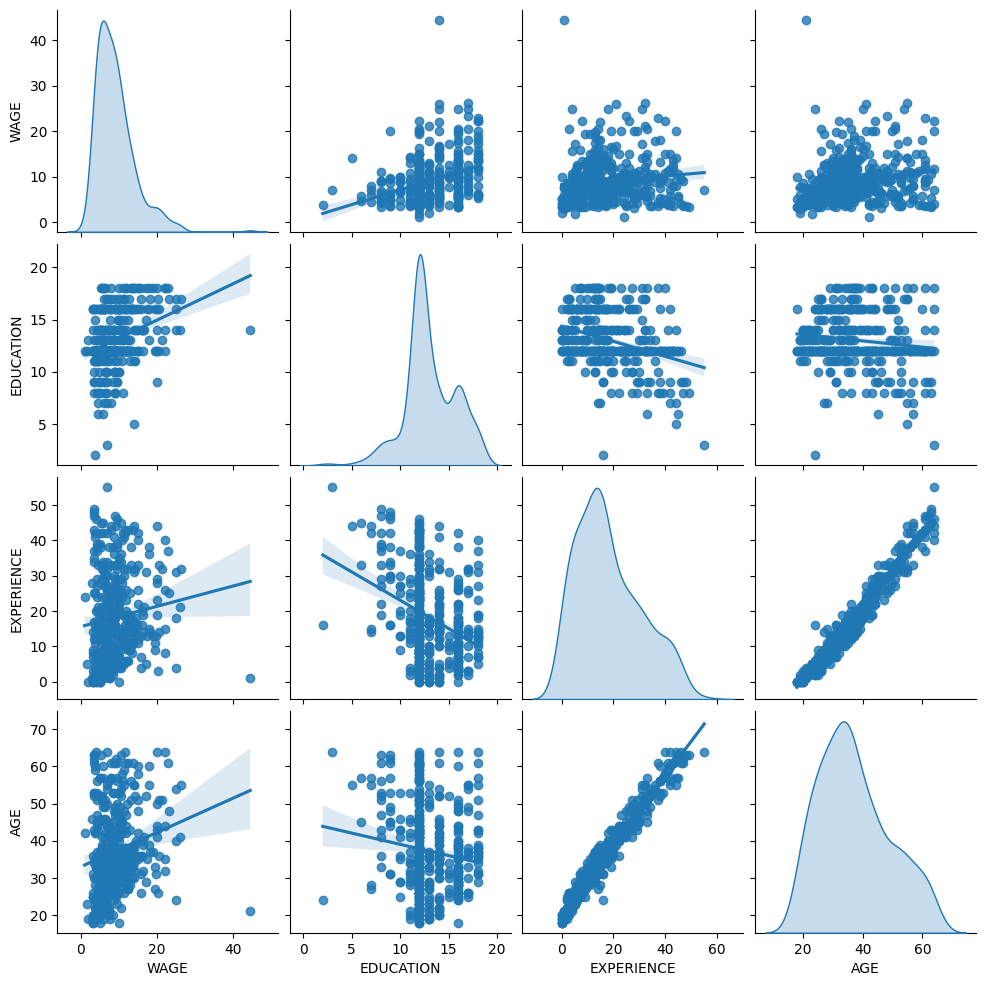

In [7]:
train_dataset = X_train.copy()
train_dataset.insert(0, "WAGE", y_train)
_ = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

Looking closely at the WAGE distribution reveals that it has a
long tail. For this reason, we should take its logarithm
to turn it approximately into a normal distribution (linear models such
as ridge or lasso work best for a normal distribution of error).

The WAGE is increasing when EDUCATION is increasing.
Note that the dependence between WAGE and EDUCATION
represented here is a marginal dependence, i.e., it describes the behavior
of a specific variable without keeping the others fixed.

Also, the EXPERIENCE and AGE are strongly linearly correlated.

## The machine-learning pipeline

To design our machine-learning pipeline, we first manually
check the type of data that we are dealing with:

In [8]:
survey.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   EDUCATION   534 non-null    float64 
 1   SOUTH       534 non-null    category
 2   SEX         534 non-null    category
 3   EXPERIENCE  534 non-null    float64 
 4   UNION       534 non-null    category
 5   AGE         534 non-null    float64 
 6   RACE        534 non-null    category
 7   OCCUPATION  534 non-null    category
 8   SECTOR      534 non-null    category
 9   MARR        534 non-null    category
dtypes: category(7), float64(3)
memory usage: 17.2 KB


As seen previously, the dataset contains columns with different data types
and we need to apply a specific preprocessing for each data types.
In particular categorical variables cannot be included in linear model if not
coded as integers first. In addition, to avoid categorical features to be
treated as ordered values, we need to one-hot-encode them.
Our pre-processor will

- one-hot encode (i.e., generate a column by category) the categorical
  columns, only for non-binary categorical variables;
- as a first approach (we will see after how the normalisation of numerical
  values will affect our discussion), keep numerical values as they are.



## Processing the dataset

In [9]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

categorical_columns = ["RACE", "OCCUPATION", "SECTOR", "MARR", "UNION", "SEX", "SOUTH"]
numerical_columns = ["EDUCATION", "EXPERIENCE", "AGE"]

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_columns),
    remainder="passthrough",
    verbose_feature_names_out=False,  # avoid to prepend the preprocessor names
)

To describe the dataset as a linear model we use a ridge regressor
with a very small regularization and to model the logarithm of the WAGE.



## Fitting the linear regression model 

In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10
    ),
)
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH'])],
                                   verbose_feature_names_out=False)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=1e-10)))])

## Model evaluation 

Again, we check the performance of the computed
model using, for example, the median absolute error of the model and the R
squared coefficient.



In [13]:
y_pred = model.predict(X_train)
mae = median_absolute_error(y_train, y_pred)
string_score = f"MAE on training set: {mae:.2f} $/hour"
y_pred = model.predict(X_test)
mae = median_absolute_error(y_test, y_pred)
string_score += f"\nMAE on testing set: {mae:.2f} $/hour"

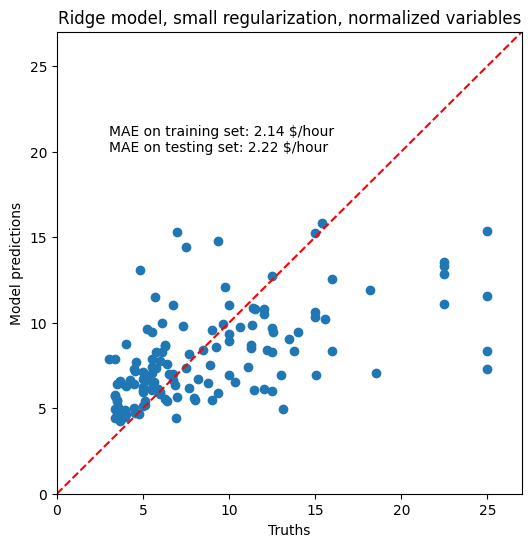

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.text(3, 20, string_score)

plt.title("Ridge model, small regularization, normalized variables")
plt.ylabel("Model predictions")
plt.xlabel("Truths")
plt.xlim([0, 27])
_ = plt.ylim([0, 27])

## Feature importance


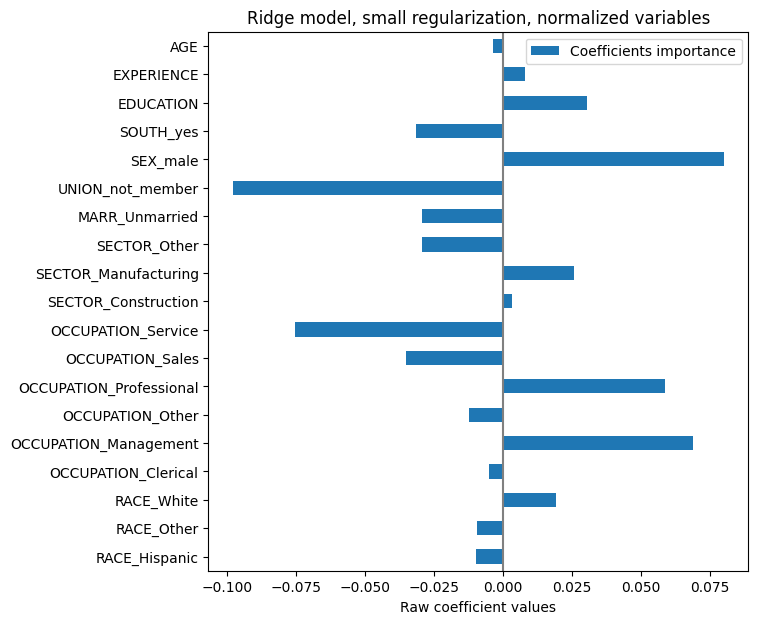

In [36]:
# feature_names = model[:-1].get_feature_names_out()
feature_names = ['RACE_Hispanic', 'RACE_Other', 'RACE_White', 'OCCUPATION_Clerical',
       'OCCUPATION_Management', 'OCCUPATION_Other',
       'OCCUPATION_Professional', 'OCCUPATION_Sales',
       'OCCUPATION_Service', 'SECTOR_Construction',
       'SECTOR_Manufacturing', 'SECTOR_Other', 'MARR_Unmarried',
       'UNION_not_member', 'SEX_male', 'SOUTH_yes', 'EDUCATION',
       'EXPERIENCE', 'AGE']

coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model, small regularization, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

Indeed, from the plot above the most important factor in determining WAGE
appears to be the
variable UNION, even if our intuition might tell us that variables
like EXPERIENCE should have more impact.

Looking at the coefficient plot to gauge feature importance can be
misleading as some of them vary on a small scale, while others, like AGE,
varies a lot more, several decades.

This is visible if we compare the standard deviations of different
features.



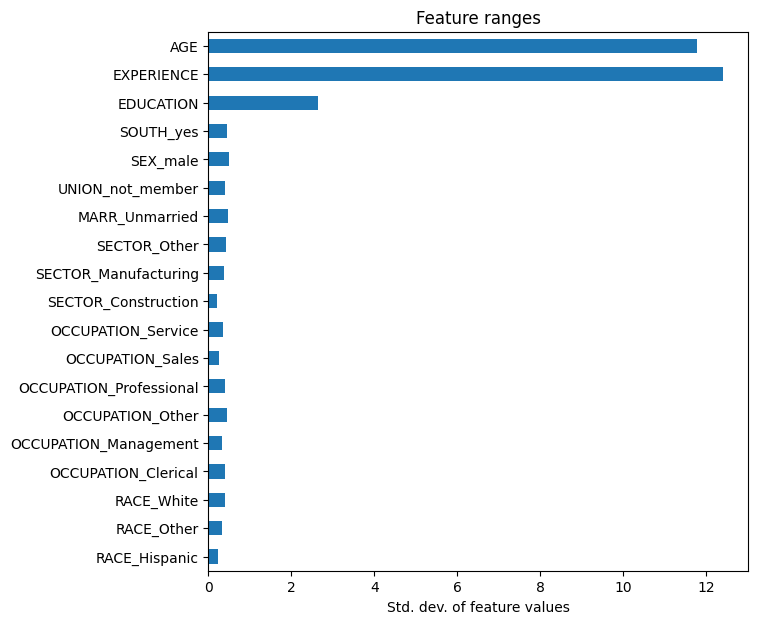

In [37]:
X_train_preprocessed = pd.DataFrame(
    model[:-1].transform(X_train), columns=feature_names
)

X_train_preprocessed.std(axis=0).plot.barh(figsize=(9, 7))
plt.title("Feature ranges")
plt.xlabel("Std. dev. of feature values")
plt.subplots_adjust(left=0.3)

Multiplying the coefficients by the standard deviation of the related
feature would reduce all the coefficients to the same unit of measure.
As we will see `after<scaling_num>` this is equivalent to normalize
numerical variables to their standard deviation,
as $y = \sum{coef_i \times X_i} =
\sum{(coef_i \times std_i) \times (X_i / std_i)}$.

In that way, we emphasize that the
greater the variance of a feature, the larger the weight of the corresponding
coefficient on the output, all else being equal.



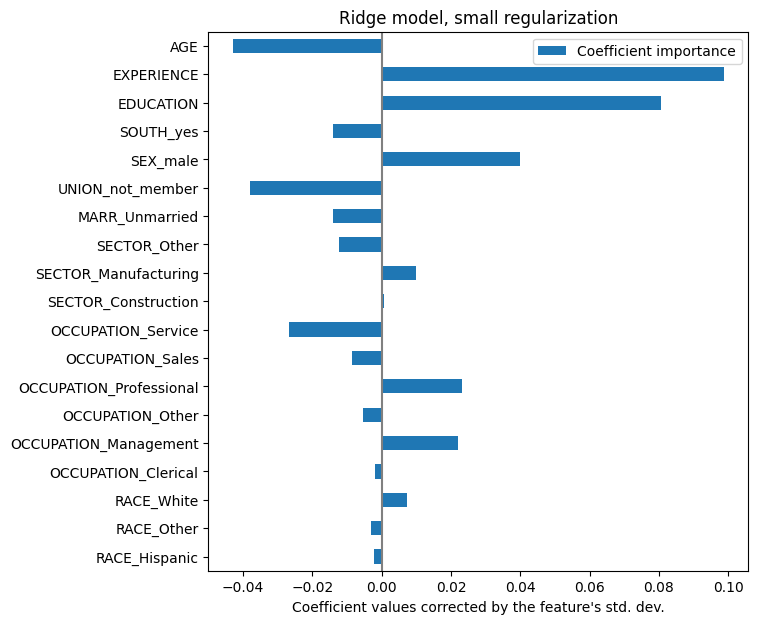

In [38]:
coefs = pd.DataFrame(
    model[-1].regressor_.coef_ * X_train_preprocessed.std(axis=0),
    columns=["Coefficient importance"],
    index=feature_names,
)
coefs.plot(kind="barh", figsize=(9, 7))
plt.xlabel("Coefficient values corrected by the feature's std. dev.")
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

Now that the coefficients have been scaled, we can safely compare them.

<div class="alert alert-danger"><h4>Warning</h4><p>Why does the plot above suggest that an increase in age leads to a
  decrease in wage? Why the `initial pairplot
  <marginal_dependencies>` is telling the opposite?</p></div>

The plot above tells us about dependencies between a specific feature and
the target when all other features remain constant, i.e., **conditional
dependencies**. An increase of the AGE will induce a decrease
of the WAGE when all other features remain constant. On the contrary, an
increase of the EXPERIENCE will induce an increase of the WAGE when all
other features remain constant.
Also, AGE, EXPERIENCE and EDUCATION are the three variables that most
influence the model.


## Checking the variability of the coefficients

We can check the coefficient variability through cross-validation:
it is a form of data perturbation (related to
[resampling](https://en.wikipedia.org/wiki/Resampling_(statistics))).

If coefficients vary significantly when changing the input dataset
their robustness is not guaranteed, and they should probably be interpreted
with caution.

In [18]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)

coefs = pd.DataFrame(
    [
        est[-1].regressor_.coef_ * est[:-1].transform(X.iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X, y))
    ],
    columns=feature_names,
)

/Users/hassanalsawadi/Library/Caches/pypoetry/virtualenvs/essential-statistics-for-machine-learning-TSRo-x6U-py3.8/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)
/Users/hassanalsawadi/Library/Caches/pypoetry/virtualenvs/essential-statistics-for-machine-learning-TSRo-x6U-py3.8/lib/python3.8/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


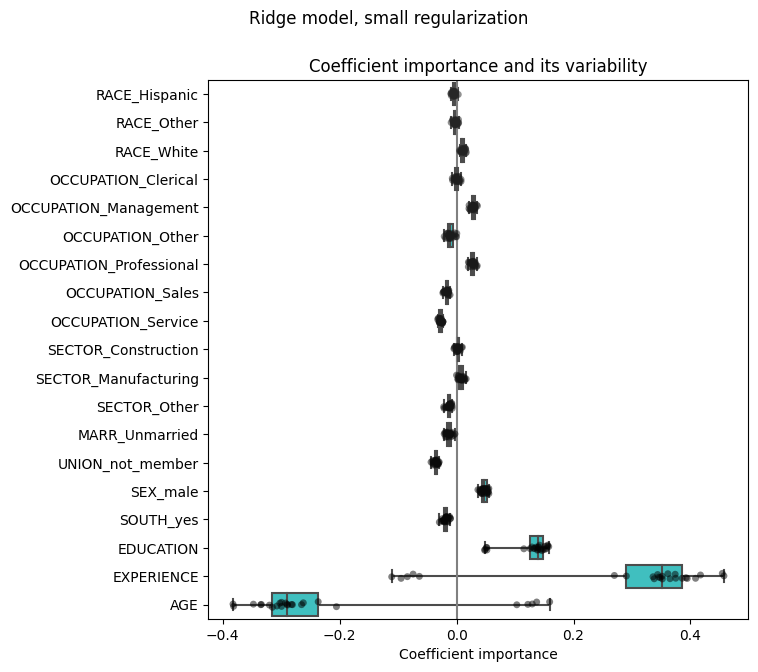

In [19]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.suptitle("Ridge model, small regularization")
plt.subplots_adjust(left=0.3)